## Doing inference with SageMaker Built-in Object Detection model

## setup

In [ ]:
%matplotlib inline

In [1]:
!pip install opencv-python
!pip install gluoncv

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/mxnet_p36/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/mxnet_p36/bin/python -m pip install --upgrade pip' command.


In [2]:
from matplotlib import pyplot as plt
from gluoncv.utils import download, viz
import numpy as np
import mxnet as mx
import json
import boto3
import cv2
import os

In [3]:
def make_tmp_folder(folder_name):
    try:
        os.makedirs(folder_name)
    except OSError as e:
        print("{} folder already exists".format(folder_name))

In [4]:
TMP_FOLDER = 'trained-model'
make_tmp_folder(TMP_FOLDER)

trained-model folder already exists


In [5]:
!cat $TMP_FOLDER/hyperparams.json

{"base_network": "vgg-16", "use_pretrained_model": "1", "num_classes": "8", "mini_batch_size": "8", "epochs": "500", "learning_rate": "0.001", "lr_scheduler_step": "", "lr_scheduler_factor": "0.1", "optimizer": "sgd", "momentum": "0.9", "weight_decay": "0.0005", "overlap_threshold": "0.5", "nms_threshold": "0.45", "num_training_samples": "53", "image_shape": "512", "_tuning_objective_metric": "", "_kvstore": "device", "kv_store": "device", "_num_kv_servers": "auto", "label_width": "350", "freeze_layer_pattern": "", "nms_topk": "400", "early_stopping": "False", "early_stopping_min_epochs": "10", "early_stopping_patience": "5", "early_stopping_tolerance": "0.0", "_begin_epoch": "0"}

In [ ]:
!ls -alh $TMP_FOLDER

## Doing inference with the model on local host

In [6]:
def get_ctx():
    try:
        gpus = mx.test_utils.list_gpus()
        if len(gpus) > 0:
            ctx = []
            for gpu in gpus:
                ctx.append(mx.gpu(gpu))
        else:
            ctx = [mx.cpu()]
    except:
        ctx = [mx.cpu()]
    return ctx

ctx = get_ctx()[0]
ctx

cpu(0)

In [22]:
SHAPE = 512
input_shapes=[('data', (1, 3, SHAPE, SHAPE))]
confidence_threshold = 0.2
CLASSES = ['Changty','Sky','Roger','Jimmy','Kfira','Rachael','Rinns','Tclan']

## Loading the model

In [23]:
%%time

param_path=os.path.join(TMP_FOLDER, 'deploy_model_algo_1')
print("param_path: {}".format(param_path))
sym, arg_params, aux_params = mx.model.load_checkpoint(param_path, 0)
mod = mx.mod.Module(symbol=sym, label_names=[], context=ctx)
mod.bind(for_training=False, data_shapes=input_shapes)
mod.set_params(arg_params, aux_params)

param_path: trained-model/deploy_model_algo_1
CPU times: user 59 ms, sys: 77.1 ms, total: 136 ms
Wall time: 112 ms


In [24]:
from collections import namedtuple
Batch = namedtuple('Batch', ['data'])

def predict_from_file(filepath, reshape=(SHAPE, SHAPE)):
    # Switch RGB to BGR format (which ImageNet networks take)
    img = cv2.cvtColor(cv2.imread(filepath), cv2.COLOR_BGR2RGB)
   
    if img is None:
        return []

     # Resize image to fit network input
    img = cv2.resize(img, reshape)
    
    org_image = img.copy()
    img = np.swapaxes(img, 0, 2)
    img = np.swapaxes(img, 1, 2)
    img = img[np.newaxis, :]
 
    mod.forward(Batch([mx.nd.array(img)]))
    prob = mod.get_outputs()[0].asnumpy()
    prob = np.squeeze(prob)

    return prob, org_image

In [25]:
def infer(image_path, threshold=confidence_threshold):
    results, org_image = predict_from_file(image_path)
    image_name = image_path.split("/")[-1]
    
    filtered_result = results[results[:, 0] != -1]
    filtered_result = filtered_result[filtered_result[:, 1] >=threshold]
    
    return filtered_result, org_image

## Test inference on single image 

In [42]:
%%time

#prediction_image = '14465735511528.jpg'
prediction_image = 'line_637669196787939.jpg'
#prediction_image = 'IMG_4794.jpg'
#prediction_image = 'line_637535308359381.jpg'
results, org_image = infer(prediction_image)

CPU times: user 2.75 s, sys: 0 ns, total: 2.75 s
Wall time: 2.75 s


In [43]:
img = cv2.cvtColor(cv2.imread(prediction_image), cv2.COLOR_BGR2RGB)
height = img.shape[0]
width = img.shape[1]

In [44]:
results[:, (2, 4)] *= width
results[:, (3, 5)] *= height

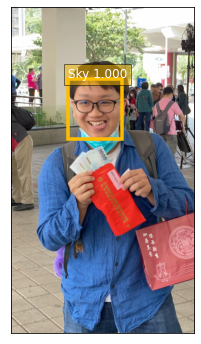

In [45]:
fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(6, 6), dpi=72)
axis=axes

#ax = viz.plot_bbox(org_image, results[:,-4:], results[:,1], results[:,0],thresh=0.1, class_names=CLASSES, ax=axis)
ax = viz.plot_bbox(img, results[:,-4:], results[:,1], results[:,0],thresh=0.1, class_names=CLASSES, ax=axis)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)